# Capstone Project (Week 2)
# Site Location for Affordable Housing Development with Neighbourhood Analysis in Manchester
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Background and Problem](#introduction)
* [Data and Exploratory Data Analysis](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Background and Problem <a name="introduction"></a>

Since 2015, 13,259 homes have been completed in the city of Manchester - however, forecasting suggests that without intervention, the city may fall short of its affordable homes target, despite various successful partnerships with the city’s registered providers where Council land is invested for affordable housing. 

A new council-run house building company will be established in Manchester in a bid to boost the delivery of affordable homes. By creating this company, the council will be able to control and set rent levels to better meet the needs of those on housing benefits. It is estimated that it could deliver around 1,800 new affordable homes, along with more than 1,000 homes for market sale and rent.






This project is aiming to find an optimal rank of location for a construction site. The outcome of this report and analysis will be targeted to Manchester City Council to filter suitable wards and potential brown site locations for affordable housing development.

It is expected that wards and areas, where there is a ***lower real estate*** cost and has a ***relatively lower density of local infrastructure and business***, are preferred to achieve their goals. This can be due to various factors. By using the tools of data gathering and analysis, mapping and machine learning, the desire locations can be identified for the Manchester City Council house building company to back up their business case for planning permission application. The clustering outcome and data visualisation will not just help identified site for affordable house building company, but also provide an opportunity for Manchester City Council to identify differences between each neighbourhood or electoral ward areas.

## Data and Exploratory Data Analysis<a name="data"></a>

For the purposed of this project, which is to identify site for potential development location, the following data will be required to allow data analysis, mapping and clustering:
* Area boundaries and corresponding coordinates within the City of Manchester
* Existing available site locations
* Existing nearby venues and their features using Foursquare
* Recent mean and median housing price
* Recent house market transaction history

Most of the data required can be obtained from the Manchester City Council site and Office for National Statistics (ONS). However due to the scope of this project and estimation purposes, some data will need to be manipulated to the form required using ArcGIS or QGIS (which is used in this project), before they are imported for analysis

### A. Area boundaries and corresponding coordinates within the City of Manchester

There is existing information of postal code area for Greater Manchester available on Wikipedia which can be scraped and used. However, the scope of this project will be focusing on the area of Manchester City instead of Greater Manchester, hence the 32 electoral ward areas within Manchester City will be used for area boundaries. This boundary information is available as shapefile from UK Ordnance Survey or as kmz file from Manchester City Council site. QGIS is used here to import the kmz file for centroid calculation and geoJSON which will be used for mapping during the analysis.

<center><img src="./figure1.png" width="800"></center>

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


As these wards boundaries are downloaded from Manchester City Council site, the data are in the form of shapefiles and polygons. To allow venues explore in Foursquare, centroid coordinates are required for each ward area. QGIS is used here to run the geometric analysis and export the centroid coordinates for every ward polygon. The data for these 32 wards are saved as `csv` file and can be imported as a dataframe.

In [2]:
file_name = "manchester_wards_centroids.csv"
wards = pd.read_csv(file_name)
print('The dataframe has {} wards.'.format(len(wards)))
wards.head()

The dataframe has 32 wards.


,Name,xcoord,ycoord
0,Chorlton,-2.283133,53.440811
1,Didsbury West,-2.244059,53.419990
2,Crumpsall,-2.236120,53.515854
3,Old Moat,-2.235121,53.435515
4,Fallowfield,-2.227778,53.445067


The name of the columns need to be changed. Additionally the ycoord represents latitude and xcoord represents longitude.

In [3]:
# rename columns
wards = wards.rename(columns={'Name': 'ward', 'xcoord': 'longitude', 'ycoord': 'latitude'})
wards = wards[['ward', 'latitude', 'longitude']]
wards.head()

,ward,latitude,longitude
0,Chorlton,53.440811,-2.283133
1,Didsbury West,53.419990,-2.244059
2,Crumpsall,53.515854,-2.236120
3,Old Moat,53.435515,-2.235121
4,Fallowfield,53.445067,-2.227778


### B. Existing available site locations
Point data showing Brownfield land identified as being potentially available for housing development. Manchester's Local Plan and other frameworks and strategies, showing which areas within the city have the capacity to accommodate new housing. In addition it can be used by developers wanting to identify suitable sites for development in Manchester. These point data are also imported into QGIS in order to analyse which ward a site belongs to, as this action is spatial analysis based on ward boundaries, which is difficult to achieve within the notebook.
<center><img src="./figure2.png" width="800"></center>

Again, QGIS is used here to run the geometric analysis to assign ward to each brownfield construction site point. The data for these existing available site locations are saved as `csv` file and can be imported as a dataframe.

In [4]:
file_name = "brownfield_site_location.csv"
sites = pd.read_csv(file_name)
print('The dataframe has {} existing brownfield site locations.'.format(sites.shape[0]))
sites.head()

The dataframe has 235 existing brownfield site locations.


,FID,SiteNameAd,GeoX,GeoY,Hectares,Name
0,62,102 Manchester Road,-2.277369,53.446061,0.13,Chorlton
1,91,102 Manchester Road,-2.277369,53.446061,0.13,Chorlton
2,150,Chorlton District Centre,-2.279022,53.443306,1.75,Chorlton
3,166,Chorlton Baths,-2.276849,53.447113,0.28,Chorlton
4,145,95 Palatine Road,-2.235446,53.425988,0.26,Didsbury West


The name of the columns need to be manipulates. Additionally the ycoord represents latitude and xcoord represents longitude.

The Hectares column to be renamed to `area` with the unit of square metre.

In [5]:
# rename columns
sites = sites.rename(columns={
    'FID': 'site_id', 
    'SiteNameAd': 'site_address', 
    'GeoX': 'longitude', 
    'GeoY': 'latitude', 
    'Hectares': 'area', 
    'Name': 'ward',
    })
# convert area unit from hectares to square metre
sites['area'] = sites[['area']]*10000
sites.head()

,site_id,site_address,longitude,latitude,area,ward
0,62,102 Manchester Road,-2.277369,53.446061,1300.0,Chorlton
1,91,102 Manchester Road,-2.277369,53.446061,1300.0,Chorlton
2,150,Chorlton District Centre,-2.279022,53.443306,17500.0,Chorlton
3,166,Chorlton Baths,-2.276849,53.447113,2800.0,Chorlton
4,145,95 Palatine Road,-2.235446,53.425988,2600.0,Didsbury West


Exploratory data analysis on existing brownfield site locations to shown distribution of sites.

In [6]:
site_count = sites[['site_id', 'ward']].groupby(['ward']).count().reset_index()
print('There are {} wards that have available site in 32 wards.'.format(len(site_count)))

There are 31 wards that have available site in 32 wards.


There is a site which does not have any site, that can be found and add 0 value to the list.

In [7]:
ward_no_site = wards['ward'][~wards['ward'].isin(site_count['ward'])].tolist()
print('There is {} ward that has no site and it is {}'.format(len(ward_no_site), ward_no_site))

There is 1 ward that has no site and it is ['Brooklands']


In [8]:
site_count.iloc[-1] = [ward_no_site[0], 0]
site_count

,ward,site_id
0,Ancoats & Beswick,16
1,Ardwick,5
2,Baguley,3
3,Burnage,5
4,Charlestown,5
5,Cheetham,6
6,Chorlton,4
7,Chorlton Park,3
8,Clayton & Openshaw,3
9,Crumpsall,5


In [9]:
# Compare the number of available sites in each ward
site_count = site_count.rename(columns={'site_id': 'site_count'}).sort_values(by='site_count', ascending=False).set_index('ward')

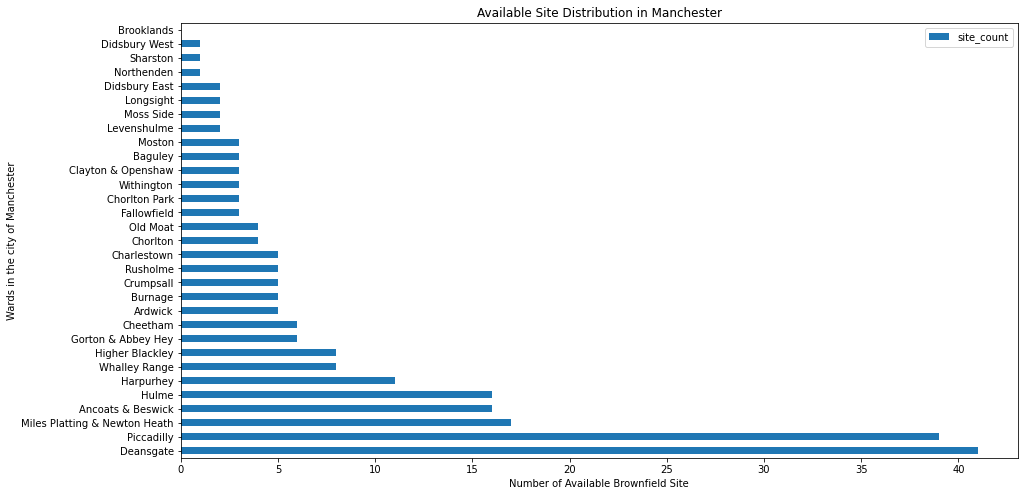

In [10]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

site_count.plot(kind='barh', figsize=(15, 8))

plt.xlabel('Number of Available Brownfield Site')
plt.ylabel('Wards in the city of Manchester')
plt.title('Available Site Distribution in Manchester')

plt.show()


### C. Existing nearby venues and their features using Foursquare
Using centroid coordinates of each ward in Manchester city, API calls to Foursquare can be used to get access to POI data for venues within each ward, and search rank venues and get real-time data access. Request package will be used to download venue content for features for each ward.

In [11]:
# Identify centre coordinates of Manchester City
address = 'Manchester, England'

geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manchester are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manchester are 53.4794892, -2.2451148.


#### Create a map of New York with neighborhoods superimposed on top.

In [70]:
# create map of New York using latitude and longitude values
map_manchester = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, ward, site in zip(sites['latitude'], sites['longitude'], sites['ward'], sites['site_id']):
    label = '{}, {}'.format(site, ward)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manchester)  
    
map_manchester

Folium Map for Github Display
<center><img src="./folium_1.png"></center>

Define Foursquare Credentials and Version - credentials information imported from local credentials.json file.

In [13]:
with open('credentials.json') as f:
    data = json.load(f)
    CLIENT_ID = data['CLIENT_ID'] 
    CLIENT_SECRET = data['CLIENT_SECRET']  

VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
print('Your credentails loaded successfully.')

Your credentails loaded successfully.


Define information of interest and filter dataframe - define this function that extracts the category of the venue

In [14]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Define the below function to extracts nearby venue for each location:

In [15]:
def getNearbyVenues(sites, wards, latitudes, longitudes, radius=500):
    
    venues_list=[]
    print('Obtaining venues around site locations:', end='')

    for site, ward, lat, lng in zip(sites, wards, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            site, 
            ward,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        print(' .', end='')
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['site_id','ward', 
                  'site_latitude', 
                  'site_longitude', 
                  'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    print(' done.')
    return(nearby_venues)

Now run the above function on each site and create a new dataframe called _manchester_venues_.

In [16]:
manchester_venues = getNearbyVenues(
    sites=sites['site_id'],
    wards=sites['ward'],
    latitudes=sites['latitude'],
    longitudes=sites['longitude'],
    )

Obtaining venues around site locations: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . done.


Check the size of the resulting dataframe

In [17]:
print(manchester_venues.shape)
manchester_venues.head()

(6870, 8)


,site_id,ward,site_latitude,site_longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,62,Chorlton,53.446061,-2.277369,Pi,53.446778,-2.277464,Bar
1,62,Chorlton,53.446061,-2.277369,Barbakan Delicatessen,53.445717,-2.277927,Deli / Bodega
2,62,Chorlton,53.446061,-2.277369,The Font,53.447314,-2.277344,Pub
3,62,Chorlton,53.446061,-2.277369,Unicorn Grocery,53.446759,-2.277328,Grocery Store
4,62,Chorlton,53.446061,-2.277369,The Beagle,53.443791,-2.278031,Gastropub


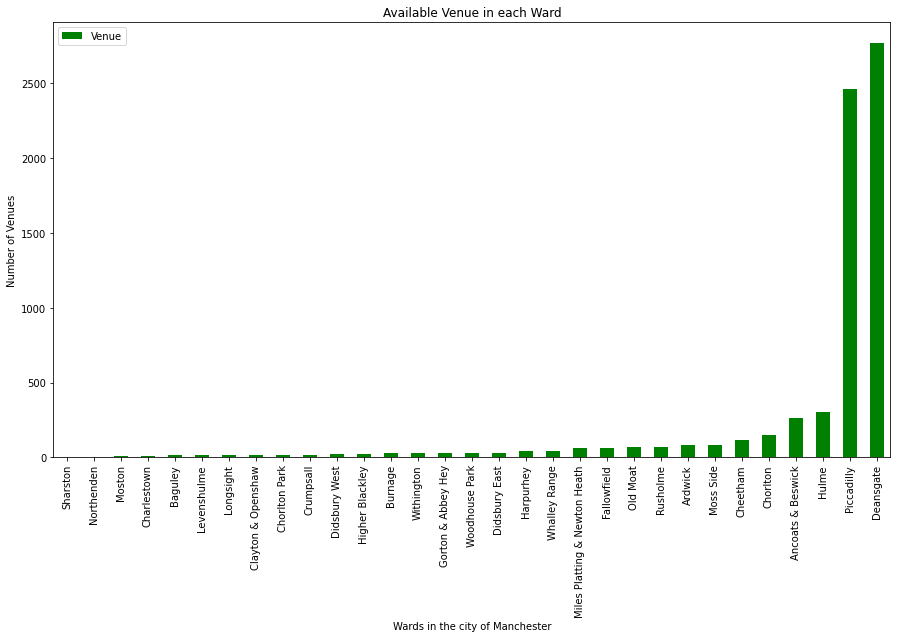

In [79]:
ward_grouped = manchester_venues[['ward', 'Venue']].groupby('ward').count().sort_values(by='Venue')

ward_grouped.plot(kind='bar', color='g', figsize=(15, 8))

plt.xlabel('Wards in the city of Manchester')
plt.ylabel('Number of Venues')
plt.title('Available Venue in each Ward')

plt.show()

In [18]:
print(manchester_venues.groupby('site_id').count().head())
# show how many unique categories can be curated from all the return venues
print('There are {} uniques categories.'.format(len(manchester_venues['Venue Category'].unique())))
print('There are {} uniques sites that have venues.'.format(len(manchester_venues['site_id'].unique())))

         ward  site_latitude  site_longitude  Venue  Venue Latitude  \
site_id                                                               
1           2              2               2      2               2   
2           7              7               7      7               7   
3           7              7               7      7               7   
4          71             71              71     71              71   
5          31             31              31     31              31   

         Venue Longitude  Venue Category  
site_id                                   
1                      2               2  
2                      7               7  
3                      7               7  
4                     71              71  
5                     31              31  
There are 226 uniques categories.
There are 233 uniques sites that have venues.


### Analyze Each Neighborhood

In [19]:
# one hot encoding
manchester_onehot = pd.get_dummies(manchester_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manchester_onehot['site_id'] = manchester_venues['site_id'] 

# move neighborhood column to the first column
fixed_columns = [manchester_onehot.columns[-1]] + list(manchester_onehot.columns[:-1])
manchester_onehot = manchester_onehot[fixed_columns]

print('There are {} venues and {} unique categories'.format(manchester_onehot.shape[0], manchester_onehot.shape[1]-1))

manchester_grouped = manchester_onehot.groupby('site_id').mean().reset_index()
manchester_grouped.shape

There are 6870 venues and 226 unique categories


(233, 227)

There are 235 sites - this suggests 3 of the sites do not have any nearby venues. However for this analysis they are required to be included in the cluster.

In [20]:
site_no_venue = sites['site_id'][~sites['site_id'].isin(manchester_grouped['site_id'])].tolist()
print('There is {} ward that has no site and it is {}'.format(len(site_no_venue), site_no_venue))
for i in range(len(site_no_venue)):
    manchester_grouped.loc[len(manchester_grouped)] = 0
    manchester_grouped.loc[len(manchester_grouped)-1, 'site_id'] = site_no_venue[i]
    
print('There are {} sites in manchester_grouped dataframe'.format(manchester_grouped.shape[0]))
manchester_grouped.tail()

There is 2 ward that has no site and it is [104, 163]
There are 235 sites in manchester_grouped dataframe


,site_id,Adult Boutique,Afghan Restaurant,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Store,Betting Shop,Bike Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Canal,Canal Lock,Caribbean Restaurant,Casino,Caucasian Restaurant,Check Cashing Service,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Cafeteria,College Gym,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cricket Ground,Cultural Center,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Discount Store,Dive Bar,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gelato Shop,Gift Shop,Go Kart Track,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Health & Beauty Service,Health Food Store,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Insurance Office,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Lebanese Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,New American Restaurant,Nightclub,Office,Other Repair Shop,Outdoor Event Space,Outdoor Supply Store,Outlet Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pier,Piercing Parlor,Pizza Place,Platform,Playground,Plaza,Pool,Pool Hall,Pop-Up Shop,Portuguese Restaurant,Pub,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Rock Club,Sandwich Place,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Snack Place,Soccer Field,Soup Place,South Indian Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Toy / Game Store,Track Stadium,Trail,Train Station,Tram Station,Turkish Restaurant,Used Auto Dealership,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Yemeni Restaurant
230,233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

Put that into a _pandas_ dataframe

In [21]:
# write a function to sort the venues in descending order:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [22]:
# create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['site_id']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
site_venues_sorted = pd.DataFrame(columns=columns)
site_venues_sorted['site_id'] = manchester_grouped['site_id']

for ind in np.arange(manchester_grouped.shape[0]):
    site_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manchester_grouped.iloc[ind, :], num_top_venues)

site_venues_sorted.head()

,site_id,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Pub,Adult Boutique,Performing Arts Venue,Music Venue,New American Restaurant,Nightclub,Office,Other Repair Shop,Outdoor Event Space,Outdoor Supply Store
1,2,Supermarket,Discount Store,Coffee Shop,Gym,Bus Stop,Gym / Fitness Center,Office,Other Repair Shop,Outdoor Event Space,Nightclub
2,3,Bar,Train Station,Grocery Store,Coffee Shop,Lake,Café,Dessert Shop,Other Repair Shop,Outdoor Event Space,Outdoor Supply Store
3,4,Coffee Shop,Italian Restaurant,Bar,Plaza,Sandwich Place,Café,Pub,Restaurant,Bookstore,Grocery Store
4,5,Music Venue,Bus Stop,Bar,Chinese Restaurant,Grocery Store,Coffee Shop,Supermarket,Café,Hotel,Museum


### D. Recent Mean Housing Price
Mean and median price paid for residential property in England and Wales, by property type and electoral ward. Annual data which is updated quarterly. These data are part of the House Price Statistics for Small Areas (HPSSAs) release, produced by Office of National Statistics and HM Land Registry. Statistics are reported for different types of dwelling including all types, detached, semi-detached, terraced houses and flats/maisonettes as well as a newbuild / existing dwelling breakdown.

In [23]:
file_mean_price = 'mean price paid by wards.csv'
mean_house_price = pd.read_csv(file_mean_price)
print("There are {} wards data and {} columns of house price.".format(mean_house_price.shape[0], mean_house_price.shape[1]))
mean_house_price.columns

There are 32 wards data and 104 columns of house price.


Index(['Local authority code', 'Local authority name', 'Ward code',
       'Ward name', 'Year ending Dec 1995', 'Year ending Mar 1996',
       'Year ending Jun 1996', 'Year ending Sep 1996', 'Year ending Dec 1996',
       'Year ending Mar 1997',
       ...
       'Year ending Jun 2018', 'Year ending Sep 2018', 'Year ending Dec 2018',
       'Year ending Mar 2019', 'Year ending Jun 2019', 'Year ending Sep 2019',
       'Year ending Dec 2019', 'Year ending Mar 2020', 'Year ending Jun 2020',
       'Year ending Sep 2020'],
      dtype='object', length=104)

For the purposed and csope of this project, the data for the most recent 4 quarters will be used and calcuate their overall average.

In [24]:
mean_house_price = mean_house_price[["Ward name", "Year ending Dec 2019", "Year ending Mar 2020", "Year ending Jun 2020", "Year ending Sep 2020"]]
mean_house_price = mean_house_price.rename(columns={
    'Ward name': 'ward', 
    'Year ending Dec 2019': 'Q4_2019', 
    'Year ending Mar 2020': 'Q1_2020',
    'Year ending Jun 2020': 'Q2_2020',
    'Year ending Sep 2020': 'Q3_2020',
    })
# remove all comma from numeric figures
mean_house_price.replace(',', '', regex=True, inplace=True)    
#convert strings into numeric values before calculation
mean_house_price[['Q4_2019', 'Q1_2020', 'Q2_2020', 'Q3_2020']] = mean_house_price[['Q4_2019', 'Q1_2020', 'Q2_2020', 'Q3_2020']].astype(int)
#calculate average 
mean_house_price['avg_price'] = mean_house_price[['Q4_2019', 'Q1_2020', 'Q2_2020', 'Q3_2020']].mean(axis=1)
print("There are {} wards data and {} columns of house price.".format(mean_house_price.shape[0], mean_house_price.shape[1]))
mean_house_price.head()


There are 32 wards data and 6 columns of house price.


,ward,Q4_2019,Q1_2020,Q2_2020,Q3_2020,avg_price
0,Ancoats & Beswick,249300,255368,253860,255205,253433.25
1,Ardwick,200671,204674,209456,211164,206491.25
2,Baguley,157226,160757,162586,167839,162102.00
3,Brooklands,195927,201087,203204,210834,202763.00
4,Burnage,221275,225661,227593,231481,226502.50


In [25]:
# import geoJSON file for house price chrolopleth
manchester_geo = r'manchester_city_wards.geojson'
print('GeoJSON file imported!')

GeoJSON file imported!


In [68]:
map_house_price = folium.Map(location=[latitude, longitude], zoom_start=11)

map_house_price.choropleth(
    geo_data=manchester_geo,
    data=mean_house_price,
    columns=['ward', 'avg_price'],
    key_on='feature.properties.Name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Manchester Mean House Price'
)
map_house_price

Folium Map for Github Display
<center><img src="./folium_2.png"></center>

Mean house price can be added to the `manchester_grouped` DataFrame so that clustering will take house price into consideration.

In [27]:
# merge mean house price with site data
site_with_price = sites.join(mean_house_price.set_index('ward'), on='ward')
print(site_with_price.head())
# extract site id and average price only
site_id_with_price = site_with_price[['site_id', 'avg_price']]
site_id_with_price.head()

   site_id              site_address  longitude   latitude     area  \
0       62       102 Manchester Road  -2.277369  53.446061   1300.0   
1       91       102 Manchester Road  -2.277369  53.446061   1300.0   
2      150  Chorlton District Centre  -2.279022  53.443306  17500.0   
3      166            Chorlton Baths  -2.276849  53.447113   2800.0   
4      145          95 Palatine Road  -2.235446  53.425988   2600.0   

            ward  Q4_2019  Q1_2020  Q2_2020  Q3_2020  avg_price  
0       Chorlton   327796   327998   341355   352494  337410.75  
1       Chorlton   327796   327998   341355   352494  337410.75  
2       Chorlton   327796   327998   341355   352494  337410.75  
3       Chorlton   327796   327998   341355   352494  337410.75  
4  Didsbury West   372794   364540   350386   352423  360035.75  


,site_id,avg_price
0,62,337410.75
1,91,337410.75
2,150,337410.75
3,166,337410.75
4,145,360035.75


Now the `manchester_grouped` can add avergae house price as an extra field for clustering. This will mean the data needs to be standardised later before clustering analysis.

In [28]:
# add price to manchester_grouped
manchester_features = manchester_grouped.join(site_id_with_price.set_index("site_id"), on='site_id')
# change order of columns so that house price is after site_id
cols = manchester_features.columns.tolist()
cols = [cols[0]] + cols[-1:] + cols[1:-1]
manchester_features = manchester_features[cols]

print(manchester_features.shape)
manchester_features.head()

(235, 228)


,site_id,avg_price,Adult Boutique,Afghan Restaurant,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Store,Betting Shop,Bike Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Canal,Canal Lock,Caribbean Restaurant,Casino,Caucasian Restaurant,Check Cashing Service,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Cafeteria,College Gym,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cricket Ground,Cultural Center,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Discount Store,Dive Bar,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gelato Shop,Gift Shop,Go Kart Track,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Health & Beauty Service,Health Food Store,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Insurance Office,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Lebanese Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,New American Restaurant,Nightclub,Office,Other Repair Shop,Outdoor Event Space,Outdoor Supply Store,Outlet Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pier,Piercing Parlor,Pizza Place,Platform,Playground,Plaza,Pool,Pool Hall,Pop-Up Shop,Portuguese Restaurant,Pub,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Rock Club,Sandwich Place,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Snack Place,Soccer Field,Soup Place,South Indian Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Toy / Game Store,Track Stadium,Trail,Train Station,Tram Station,Turkish Restaurant,Used Auto Dealership,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Yemeni Restaurant
0,1,163799.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.

A quick histogram can show distribution of sites in different price ranges:

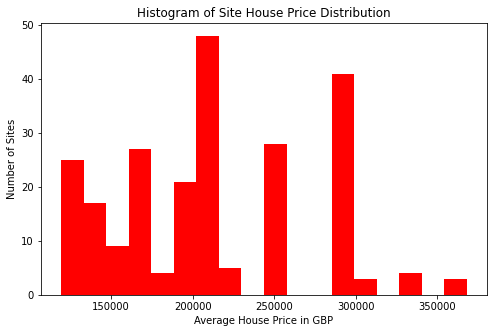

In [29]:
manchester_features['avg_price'].plot(kind='hist', figsize=(8, 5), bins=18, color='r')

plt.title('Histogram of Site House Price Distribution') # add a title to the histogram
plt.ylabel('Number of Sites') # add y-label
plt.xlabel('Average House Price in GBP') # add x-label

plt.show()

## Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting sites in Manchester that have low venues density, low existing housr price.

During data collection, manipulation and data exploratory analysis above, the essential data is collected: 
* Location and category of all the venues within 500m from each site
* Identified and calculate average house price in each ward and assign it to each site
* Distribution of site in each ward

Next step in our analysis will be calculation and exploration of '**venue density**' between each brownfield site in Manchester - we will use k-means clustering to group similar site together with low number of venues and low in housr price in general, and focus our attention on those wards in Manchester. This will help to establish discussion with stakeholders. Map of all such site clusters  of those locations to identify general zones/sites addresses/wards which should be a starting point for local council planning permission.

## Analysis <a name="analysis"></a>

#### Normalizing over the standard deviation

Now the dataset needs to be normalized before they are fed to the model.  Normalization is a statistical method that helps mathematical-based algorithms to interpret features with different magnitudes and distributions equally. We use **StandardScaler()** to normalize our dataset.


In [30]:
from sklearn.preprocessing import StandardScaler
X = manchester_features.values[:,1:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

array([[-0.78405982, -0.26303037, -0.11324788, ..., -0.26776861,
        -0.06537205, -0.11087062],
       [-1.19677057, -0.26303037, -0.11324788, ..., -0.26776861,
        -0.06537205, -0.11087062],
       [ 0.26993478, -0.26303037, -0.11324788, ..., -0.26776861,
        -0.06537205, -0.11087062],
       ...,
       [-0.64151681, -0.26303037, -0.11324788, ..., -0.26776861,
        -0.06537205, -0.11087062],
       [-0.87943168, -0.26303037, -0.11324788, ..., -0.26776861,
        -0.06537205, -0.11087062],
       [-1.15035165, -0.26303037, -0.11324788, ..., -0.26776861,
        -0.06537205, -0.11087062]])

This metric can be mean, distance between data points and their cluster's centroid, which indicate how dense our clusters are or, to what extent we minimize the error of clustering. Then, looking at the change of this metric, we can find the best value for K. The initial k start from 1 to 10 is used here with n_init of 12 for each iteration.

In [31]:
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(init = "k-means++", n_clusters=k)
    km = km.fit(Clus_dataSet)
    sum_of_squared_distances.append(km.inertia_)

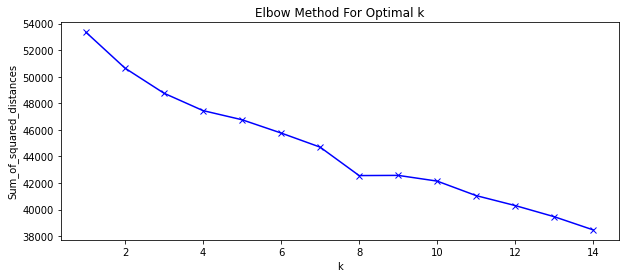

In [32]:
plt.figure(figsize=(10, 4))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

But the problem is that with increasing the number of clusters, the distance of centroids to data points will always reduce. This means increasing K will always decrease the error. So, the value of the metric as a function of K is plotted and the elbow point is determined where the rate of decrease sharply shifts. Based on the line plot above the `k_cluster` of 4 is used.

In [33]:
kclusters = 4
kmeans = KMeans(init = "k-means++", n_clusters=kclusters, n_init=12)
kmeans = kmeans.fit(Clus_dataSet)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 2, 1, 1, 1, 3, 2, 2], dtype=int32)

In [34]:
# add clustering labels
site_temp = site_venues_sorted
site_temp.insert(0, 'Cluster Labels', kmeans.labels_)

man_site_merged = site_with_price[['site_id', 'latitude', 'longitude', 'area', 'ward', 'avg_price']]

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
man_site_merged = man_site_merged.join(site_temp.set_index('site_id'), on='site_id')

man_site_merged.head(10)

,site_id,latitude,longitude,area,ward,avg_price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,62,53.446061,-2.277369,1300.0,Chorlton,337410.75,1,Bar,Pub,Grocery Store,Café,Pizza Place,Turkish Restaurant,Coffee Shop,Gastropub,Mediterranean Restaurant,Cocktail Bar
1,91,53.446061,-2.277369,1300.0,Chorlton,337410.75,1,Bar,Pub,Grocery Store,Café,Pizza Place,Turkish Restaurant,Coffee Shop,Gastropub,Mediterranean Restaurant,Cocktail Bar
2,150,53.443306,-2.279022,17500.0,Chorlton,337410.75,1,Bar,Pub,Grocery Store,Café,Pizza Place,Deli / Bodega,Turkish Restaurant,Lounge,Beer Bar,Coffee Shop
3,166,53.447113,-2.276849,2800.0,Chorlton,337410.75,1,Pub,Bar,Grocery Store,Gastropub,Pharmacy,Tea Room,Tram Station,Caribbean Restaurant,Fast Food Restaurant,Cocktail Bar
4,145,53.425988,-2.235446,2600.0,Didsbury West,360035.75,1,Pub,Italian Restaurant,Indian Restaurant,Bar,Pizza Place,Deli / Bodega,Grocery Store,Tennis Court,Bakery,Cocktail Bar
5,68,53.523338,-2.242365,26800.0,Crumpsall,158125.75,1,Business Service,Construction & Landscaping,River,Sporting Goods Shop,Adult Boutique,Performing Arts Venue,New American Restaurant,Nightclub,Office,Other Repair Shop
6,104,53.511354,-2.225136,3300.0,Crumpsall,158125.75,1,Adult Boutique,Pool Hall,Museum,Music Venue,New American Restaurant,Nightclub,Office,Other Repair Shop,Outdoor Event Space,Outdoor Supply Store
7,105,53.521111,-2.227360,2400.0,Crumpsall,158125.75,1,Café,Coffee Shop,Pharmacy,Grocery Store,Adult Boutique,Performing Arts Venue,Nightclub,Office,Other Repair Shop,Outdoor Event Space
8,126,53.516955,-2.251392,4200.0,Crumpsall,158125.75,1,Fried Chicken Joint,Gelato Shop,Halal Restaurant,Park,Pedestrian Plaza,Museum,Music Venue,New American Restaurant,Nightclub,Office
9,227,53.521037,-2.228596,3800.0,Crumpsall,158125.75,1,Home Service,Pharmacy,Café,Health & Beauty Service,Coffee Shop,Outdoor Supply Store,Pastry Shop,Park,Outlet Store,Adult Boutique


#### Visualise cluster data on folium map

In [42]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add house price choropleth to the map
map_clusters.choropleth(
    geo_data=manchester_geo,
    data=mean_house_price,
    columns=['ward', 'avg_price'],
    key_on='feature.properties.Name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Manchester Mean House Price'
)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(man_site_merged['latitude'], man_site_merged['longitude'], man_site_merged['site_id'], man_site_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Folium Map for Github Display
<center><img src="./folium_3.png"></center>

Now, examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories,a name can be assigned to each cluster. 


Cluster 0 - top venues include coffee shop, hotels and bars. Based on the nearby venues, these site might be more commercial compare to the rest. This cluster locates within Manchester Picadilly area and the Picadilly ward has the third highest average house price in Manchester. Considering that most of the properties in city centre are apartments/flats, this suggests a higher value per square metre in this cluster.

In [52]:
cluster_0 = man_site_merged.loc[man_site_merged['Cluster Labels'] == 0, man_site_merged.columns[[0,4,5] + list(range(6, man_site_merged.shape[1]))]]
cluster_0

,site_id,ward,avg_price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,42,Piccadilly,202965.75,0,Gay Bar,Hotel,Pub,Japanese Restaurant,Thai Restaurant,Coffee Shop,Indian Restaurant,Bar,Fast Food Restaurant,Sandwich Place
23,48,Piccadilly,202965.75,0,Hotel,Gay Bar,Coffee Shop,Pub,Chinese Restaurant,Indian Restaurant,Burrito Place,Sandwich Place,Bakery,Bar
35,96,Piccadilly,202965.75,0,Gay Bar,Hotel,Coffee Shop,Bar,Cocktail Bar,Pub,Indian Restaurant,Beer Bar,Chinese Restaurant,Grocery Store
37,99,Piccadilly,202965.75,0,Hotel,Gay Bar,Coffee Shop,Bar,Cocktail Bar,Beer Bar,Indian Restaurant,Pub,Thai Restaurant,Bookstore
38,100,Piccadilly,202965.75,0,Hotel,Gay Bar,Coffee Shop,Pub,Indian Restaurant,Plaza,Bakery,Bar,Chinese Restaurant,Cocktail Bar
39,134,Piccadilly,202965.75,0,Gay Bar,Hotel,Pub,Beer Bar,Coffee Shop,Indian Restaurant,Bar,Fast Food Restaurant,Adult Boutique,Chocolate Shop
48,196,Piccadilly,202965.75,0,Hotel,Gay Bar,Coffee Shop,Bar,Cocktail Bar,Beer Bar,Record Shop,Pub,Fast Food Restaurant,Chinese Restaurant
147,21,Deansgate,290092.75,0,Hotel,Coffee Shop,Plaza,Gay Bar,Pub,Bar,Thai Restaurant,Record Shop,Asian Restaurant,Pizza Place
151,36,Deansgate,290092.75,0,Hotel,Plaza,Coffee Shop,Bar,Asian Restaurant,Pub,Thai Restaurant,Record Shop,Pizza Place,Burger Joint
152,37,Deansgate,290092.75,0,Gay Bar,Pub,Bar,Hotel,Coffee Shop,Burrito Place,Indian Restaurant,Music Venue,Pizza Place,Japanese Restaurant


Cluster 1 - top venues include bars, pubs, mixture of groceries stores and takeaways. Based on the nearby venues, these site might be more residential compare to the rest. This cluster widely spread around Manchester and it is the biggest cluster. This suggests the outter skirt of Manchester, and sites locate within wards with reatively lower housr purchase price, might be more suitable for affordable housing construction

In [58]:
cluster_1 = man_site_merged.loc[man_site_merged['Cluster Labels'] == 1, man_site_merged.columns[[0,4,5] + list(range(6, man_site_merged.shape[1]))]]
cluster_1.head(10)

,site_id,ward,avg_price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,62,Chorlton,337410.75,1,Bar,Pub,Grocery Store,Café,Pizza Place,Turkish Restaurant,Coffee Shop,Gastropub,Mediterranean Restaurant,Cocktail Bar
1,91,Chorlton,337410.75,1,Bar,Pub,Grocery Store,Café,Pizza Place,Turkish Restaurant,Coffee Shop,Gastropub,Mediterranean Restaurant,Cocktail Bar
2,150,Chorlton,337410.75,1,Bar,Pub,Grocery Store,Café,Pizza Place,Deli / Bodega,Turkish Restaurant,Lounge,Beer Bar,Coffee Shop
3,166,Chorlton,337410.75,1,Pub,Bar,Grocery Store,Gastropub,Pharmacy,Tea Room,Tram Station,Caribbean Restaurant,Fast Food Restaurant,Cocktail Bar
4,145,Didsbury West,360035.75,1,Pub,Italian Restaurant,Indian Restaurant,Bar,Pizza Place,Deli / Bodega,Grocery Store,Tennis Court,Bakery,Cocktail Bar
5,68,Crumpsall,158125.75,1,Business Service,Construction & Landscaping,River,Sporting Goods Shop,Adult Boutique,Performing Arts Venue,New American Restaurant,Nightclub,Office,Other Repair Shop
6,104,Crumpsall,158125.75,1,Adult Boutique,Pool Hall,Museum,Music Venue,New American Restaurant,Nightclub,Office,Other Repair Shop,Outdoor Event Space,Outdoor Supply Store
7,105,Crumpsall,158125.75,1,Café,Coffee Shop,Pharmacy,Grocery Store,Adult Boutique,Performing Arts Venue,Nightclub,Office,Other Repair Shop,Outdoor Event Space
8,126,Crumpsall,158125.75,1,Fried Chicken Joint,Gelato Shop,Halal Restaurant,Park,Pedestrian Plaza,Museum,Music Venue,New American Restaurant,Nightclub,Office
9,227,Crumpsall,158125.75,1,Home Service,Pharmacy,Café,Health & Beauty Service,Coffee Shop,Outdoor Supply Store,Pastry Shop,Park,Outlet Store,Adult Boutique


Cluster 2 - again top venues include bars, pubs, mixture of groceries stores and takeaways. BHowever the average price is higher compare to cluster one. The folium map shows that this cluster locates in the heart of the city, between Deansgate and Picadilly. This cluster might not be suitable for affordable housing construction purposes.

In [54]:
cluster_2 = man_site_merged.loc[man_site_merged['Cluster Labels'] == 2, man_site_merged.columns[[0,4,5] + list(range(6, man_site_merged.shape[1]))]].head(10)
cluster_2

,site_id,ward,avg_price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
140,4,Deansgate,290092.75,2,Coffee Shop,Italian Restaurant,Bar,Plaza,Sandwich Place,Café,Pub,Restaurant,Bookstore,Grocery Store
142,9,Deansgate,290092.75,2,Coffee Shop,Italian Restaurant,Bar,Restaurant,Plaza,Hotel,Asian Restaurant,Grocery Store,Pub,Café
143,10,Deansgate,290092.75,2,Coffee Shop,Italian Restaurant,Plaza,Bar,Asian Restaurant,Hotel,Pub,Department Store,Sandwich Place,Bookstore
144,14,Deansgate,290092.75,2,Coffee Shop,Italian Restaurant,Bar,Bookstore,Plaza,Grocery Store,Pub,Café,Sandwich Place,Shopping Mall
145,15,Deansgate,290092.75,2,Bar,Hotel,Pub,Restaurant,Indian Restaurant,Cocktail Bar,Steakhouse,Café,Grocery Store,Gym
149,27,Deansgate,290092.75,2,Pub,Hotel,Bar,Coffee Shop,Cocktail Bar,Burrito Place,Concert Hall,Indian Restaurant,Steakhouse,Snack Place
156,50,Deansgate,290092.75,2,Hotel,Bar,Grocery Store,Indian Restaurant,Pub,Restaurant,Gym / Fitness Center,Coffee Shop,Café,Steakhouse
158,66,Deansgate,290092.75,2,Hotel,Grocery Store,Indian Restaurant,Bar,Restaurant,Pub,Gym / Fitness Center,Café,Steakhouse,Cocktail Bar
159,67,Deansgate,290092.75,2,Hotel,Grocery Store,Pub,Restaurant,Gym / Fitness Center,Indian Restaurant,Bar,Science Museum,Coffee Shop,Steakhouse
160,93,Deansgate,290092.75,2,Hotel,Pub,Bar,Restaurant,Italian Restaurant,Steakhouse,Coffee Shop,Cocktail Bar,Plaza,Indian Restaurant


Cluster 3 - top venues include hotels, bars, gyms. The average price of this cluster is highest compare to the rest. The folium map shows that this cluster locates in the heart of the city at Deansgate, where most of the existing developments are commercial. This cluster might not be suitable for affordable housing construction purposes.

In [55]:
cluster_3 = man_site_merged.loc[man_site_merged['Cluster Labels'] == 3, man_site_merged.columns[[0,4,5] + list(range(6, man_site_merged.shape[1]))]].head(10)
cluster_3

,site_id,ward,avg_price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,25,Piccadilly,202965.75,3,Pub,Tea Room,Café,Arts & Crafts Store,Brewery,Record Shop,Burger Joint,Food Court,Brazilian Restaurant,Convenience Store
19,35,Piccadilly,202965.75,3,Coffee Shop,Pub,Tea Room,Record Shop,Arts & Crafts Store,Café,Beer Bar,Burger Joint,Butcher,Concert Hall
20,39,Piccadilly,202965.75,3,Coffee Shop,Pub,Café,Record Shop,Tea Room,Indian Restaurant,Bar,Gym / Fitness Center,Beer Bar,Arts & Crafts Store
24,51,Piccadilly,202965.75,3,Coffee Shop,Pub,Café,Tea Room,Record Shop,Bar,Indian Restaurant,Beer Bar,Burger Joint,Arts & Crafts Store
25,57,Piccadilly,202965.75,3,Coffee Shop,Pub,Bar,Café,Record Shop,Italian Restaurant,Tea Room,Asian Restaurant,Indian Restaurant,Sandwich Place
26,71,Piccadilly,202965.75,3,Pub,Café,Coffee Shop,Brewery,Concert Hall,Food Court,Brazilian Restaurant,Tea Room,Burger Joint,Fried Chicken Joint
28,74,Piccadilly,202965.75,3,Coffee Shop,Beer Bar,Tea Room,Hotel,Record Shop,Convenience Store,Pub,Arts & Crafts Store,Supermarket,Brazilian Restaurant
29,75,Piccadilly,202965.75,3,Pub,Bar,Café,Coffee Shop,Hotel,Grocery Store,Brewery,Food Court,American Restaurant,Fountain
30,76,Piccadilly,202965.75,3,Coffee Shop,Pub,Tea Room,Record Shop,Café,Arts & Crafts Store,Beer Bar,Restaurant,Fried Chicken Joint,Sandwich Place
31,77,Piccadilly,202965.75,3,Pub,Coffee Shop,Tea Room,Record Shop,Café,American Restaurant,Burger Joint,Arts & Crafts Store,Donut Shop,Piercing Parlor


## Results and Discussion <a name="results"></a>

Our analysis shows that although there is wide spread of data, the biggest cluster based on nearby venues and average house price wraps around the city centre. Highest concentration of venues available from Foursquare was detected found in the Manchester city centre, and therefore many sites in the Manchester city centre may share the same features during cluster analysis. The results are also reflected in the folium map distribution - that any site locations outside of the city centre forms the same cluster. This also matches what is observed in reality, that most of the Manchester city centre is for commercial, entertainment and offices. Hence sites in the outskirt cluster are suitable for our project aim.

Based on the house price output on folium mapping, the relatively lower average house price ranges are £119,366 to £160,842 and £160,842 to 202,318. Therefore, sites within the desired cluster with ward average price lower than £202,318 can be selected as the recommendation:


In [65]:
recommended_sites = cluster_1.loc[cluster_1['avg_price'] <= 202318]

print('There are {} sites match the criteria'.format(recommended_sites.shape[0]))
print('\n')
print('The wards that are suitable for affordable housing are:', recommended_sites['ward'].unique().tolist())

There are 103 sites match the criteria


The wards that are suitable for affordable housing are: ['Crumpsall', 'Fallowfield', 'Harpurhey', 'Rusholme', 'Longsight', 'Higher Blackley', 'Charlestown', 'Miles Platting & Newton Heath', 'Moston', 'Clayton & Openshaw', 'Gorton & Abbey Hey', 'Cheetham', 'Baguley', 'Sharston', 'Moss Side', 'Woodhouse Park', 'Hulme', 'Levenshulme']


## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify site location in areas with relatively lower house price, not located within city center, and with low number of venues (especia) in order to aid stakeholders in narrowing down the search for optimal location for a new Italian restaurant. By calculating venue density distribution from Foursquare data as well as average house price from UK Office of National Satistics, differnt brownfield sites are gouped together, and ranked by their frequency of occurance. Clustering of those locations was then performed in order to create areas/wards of interest (containing greatest number of potential locations) and addresses of those zone centers were created to be used as starting points for final exploration by stakeholders.

Final decission on optimal site location will be made by Manchester city council based on specific characteristics of neighborhoods and locations in every recommended brownfield site, taking into consideration additional factors like attractiveness of each location, surrounding environment, size of the brownfield sites, realistic availability of every neighborhood.